In [1]:
cd D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl

D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl


In [2]:
# genernal
import torch
from torch import nn
import numpy as np
from architectures import encoders, decoders
from common.ops import Flatten3D, Unsqueeze3D, Reshape
from torch.nn import functional as F
import pickle
from common import dag_utils

# model loading
from gnncsvae_experiment import GNNCSVAEExperiment
from collections import defaultdict, namedtuple
import models
from common.notebook_utils import get_configured_dataset
from torch.utils.data import DataLoader
import os

# for plotting stuff
from matplotlib import cm as mpl_colormaps
from common.utils import CenteredNorm
import matplotlib.pyplot as plt 


# Multiscale + GNN structure test 

## Testing Prior GNN

In [24]:
#from common.special_modules import SimpleGNNLayer

# V, ifd, ofd =5, 2, 4

# #inp = torch.randn(size=(1, V, ifd))

# inp = torch.arange(10).type(torch.FloatTensor).view(1, V, ifd)
# print(inp)
# print("input shape: ", inp.shape)

# prior_gnn = SimpleGNNLayer(ifd, ofd, A.T, is_final_layer=True)
# print("Linear layer mat shape: ", prior_gnn.projection.weight.data.shape)
# prior_gnn.projection.weight.data = torch.Tensor(
#         [[1., 0.],
#         [0., 1.],
#         [1., 0.],
#         [0., 1.]]
# )
# prior_gnn.projection.bias.data = torch.zeros(ofd)
# print("input: ", inp)
# out = prior_gnn(inp)
# print(out)


# Load model and test prior components

In [3]:

ModelParams = namedtuple('ModelParams', ["z_dim", "l_dim", "num_labels" , "in_channels", 
                                        "image_size", "batch_size", "w_recon", "w_kld", "kl_warmup_epochs",
                                         "adjacency_matrix"])


algo_name = "GNNBasedConceptStructuredVAE"
checkpoint_path = r"D:\Saarbrucken\EDA_Research\vae-disentanglement\models\gnncsvae.ckpt"
z_dim = 5

model_params = ModelParams(
        [z_dim], 6, 0, 1, 64, 64, 1.0, 1.0, 0,
    r"D:\Saarbrucken\EDA_Research\vae-disentanglement\adjacency_matrices\dsprites_correlated.pkl"
)
exp_params = dict(
        in_channels=1,
        image_size=64,
        LR=1e-4,
        weight_decay=0.0,       
        dataset="dsprites_correlated",
        datapath=r"D:\Saarbrucken\EDA_Research\vae-disentanglement\datasets",
        droplast=True,        
        batch_size=64,
        num_workers=0,
        pin_memory=False,
        seed=123,
        evaluation_metrics=None,
        visdom_on=False,
        save_dir=None,
        max_epochs=1,
        l_zero_reg=False
)


# Model with 5-dim node feats

In [ ]:
vae_model_class = getattr(models, algo_name)
vae_model = vae_model_class(model_params)

vae_experiment = GNNCSVAEExperiment.load_from_checkpoint(
            checkpoint_path,
            vae_model=vae_model, 
            params=exp_params,
            dataset_params=dict(correlation_strength=0.2))

In [4]:

os.environ['DISENTANGLEMENT_LIB_DATA'] = r"D:\Saarbrucken\EDA_Research\vae-disentanglement\datasets"

dataset = get_configured_dataset("dsprites_correlated")
sample_loader = DataLoader(dataset, batch_size=64, shuffle = False, drop_last=True)

test_input, test_label = next(iter(sample_loader))
fwd_pass_results = vae_experiment.model.forward(test_input, current_device=test_input.device, labels = test_label)

Initialize [CorrelatedDSpritesDataset] with 737280 examples. Shape (737280, 64, 64).


In [5]:
fwd_pass_results.keys()

dict_keys(['x_recon', 'prior_mu', 'prior_logvar', 'posterior_mu', 'posterior_logvar', 'latents_predicted'])

In [7]:
fwd_pass_results['prior_mu'][1,:,:]

tensor([[ 0.2693,  0.0669,  0.7291, -0.0036,  1.4615],
        [ 0.2693,  0.0670,  0.7291, -0.0036,  1.4615],
        [ 0.2693,  0.0670,  0.7291, -0.0036,  1.4614],
        [ 0.2693,  0.0670,  0.7291, -0.0036,  1.4614],
        [ 0.2693,  0.0670,  0.7291, -0.0036,  1.4614]],
       grad_fn=<SliceBackward>)

## Check projection matrices

(10, 29)


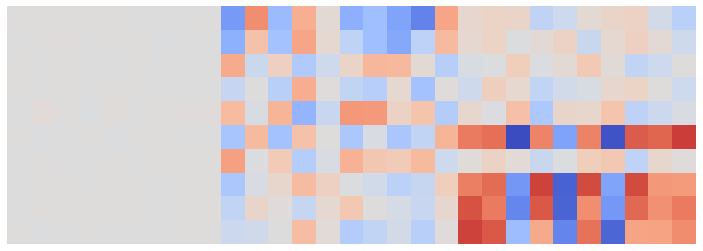

In [26]:
Ws = [vae_experiment.model.prior_gnn[i].projection.weight.detach() for i in range(3)]
Ws_to_plot = torch.cat(Ws, dim = 1).numpy()
print(Ws_to_plot.shape)
fig, axs = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=0)
axs.margins(0)
plt.axis('off')
plt.imshow(Ws_to_plot, cmap=mpl_colormaps.coolwarm, norm=CenteredNorm())

(10, 29)


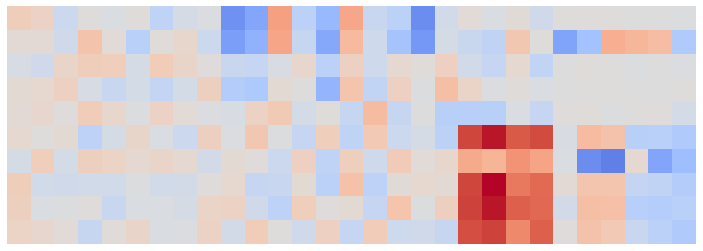

In [27]:
Ws = [vae_experiment.model.encoder_gnn[i].projection.weight.detach() for i in range(3)]
Ws_to_plot = torch.cat(Ws, dim = 1).numpy()
print(Ws_to_plot.shape)
fig, axs = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=0)
axs.margins(0)
plt.axis('off')
plt.imshow(Ws_to_plot, cmap=mpl_colormaps.coolwarm, norm=CenteredNorm())

In [28]:
 [vae_experiment.model.prior_gnn[i].projection.weight.size() for i in range(3)]

[torch.Size([10, 9]), torch.Size([10, 10]), torch.Size([10, 10])]

# For the 2D node feat dim model

In [4]:
algo_name = "GNNBasedConceptStructuredVAE"
checkpoint_path = r"D:\Saarbrucken\EDA_Research\vae-disentanglement\models\gnncsvae2d.ckpt"
z_dim = 2
model_params = ModelParams(
        [z_dim], 6, 0, 1, 64, 64, 1.0, 1.0, 0,
    r"D:\Saarbrucken\EDA_Research\vae-disentanglement\adjacency_matrices\dsprites_correlated.pkl"
)
vae_model_class = getattr(models, algo_name)
vae_model = vae_model_class(model_params)

vae_experiment = GNNCSVAEExperiment.load_from_checkpoint(
            checkpoint_path,
            vae_model=vae_model, 
            params=exp_params,
            dataset_params=dict(correlation_strength=0.2))

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
GNNBasedConceptStructuredVAE Model Initialized


(4, 17)
(4, 17)


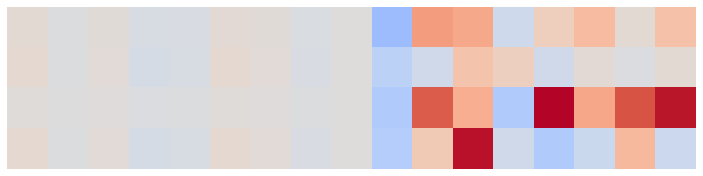

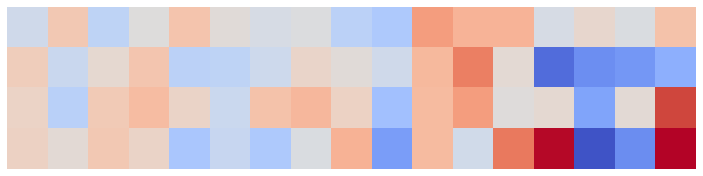

In [5]:
Ws = [vae_experiment.model.prior_gnn[i].projection.weight.detach() for i in range(3)]
Ws_to_plot = torch.cat(Ws, dim = 1).numpy()
print(Ws_to_plot.shape)
fig, axs = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=0)
axs.margins(0)
plt.axis('off')
plt.imshow(Ws_to_plot, cmap=mpl_colormaps.coolwarm, norm=CenteredNorm())

Ws = [vae_experiment.model.encoder_gnn[i].projection.weight.detach() for i in range(3)]
Ws_to_plot = torch.cat(Ws, dim = 1).numpy()
print(Ws_to_plot.shape)
fig, axs = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=0)
axs.margins(0)
plt.axis('off')
plt.imshow(Ws_to_plot, cmap=mpl_colormaps.coolwarm, norm=CenteredNorm())

# Red==positive, Blue==negative

In [8]:
vae_experiment.model.prior_gnn[0].projection.weight

Parameter containing:
tensor([[ 0.0663, -0.0145,  0.0393, -0.0600, -0.0453,  0.0603,  0.0362, -0.0366,
          0.0034],
        [ 0.0825, -0.0195,  0.0502, -0.0784, -0.0591,  0.0795,  0.0479, -0.0504,
          0.0041],
        [ 0.0316, -0.0059,  0.0186, -0.0286, -0.0209,  0.0289,  0.0167, -0.0171,
          0.0021],
        [ 0.0882, -0.0196,  0.0523, -0.0808, -0.0611,  0.0812,  0.0480, -0.0512,
          0.0043]], requires_grad=True)

In [9]:
vae_experiment.model.prior_gnn[1].projection.weight

Parameter containing:
tensor([[-0.5789,  0.6704,  0.5819, -0.1446],
        [-0.3088, -0.1422,  0.3604,  0.2173],
        [-0.4159,  1.0702,  0.5456, -0.4264],
        [-0.3753,  0.2776,  1.3673, -0.1371]], requires_grad=True)

In [7]:
vae_experiment.model.encoder_gnn[2].projection.weight

Parameter containing:
tensor([[-0.0908,  0.1481, -0.0526,  0.4951],
        [-1.6003, -1.2836, -1.1983, -0.9343],
        [ 0.1036, -1.0648,  0.0742,  1.5846],
        [ 1.8579, -1.8139, -1.3088,  1.8840]], requires_grad=True)

prior_gnn_out = None

with torch.no_grad():

    exogen_samples = torch.randn(size=(1, vae_experiment.model.num_nodes, vae_experiment.model.encoder_cnn.out_feature_dim))   
    prior_gnn_out = vae_experiment.model.prior_gnn(exogen_samples)

In [16]:
# already after the first projection, values are very similar
vae_experiment.model.prior_gnn[0](exogen_samples)

tensor([[[ 0.4093, -0.7022, -0.5794,  0.4828],
         [ 0.4093, -0.7076, -0.5766,  0.4833],
         [ 0.4480, -0.6749, -0.5656,  0.5306],
         [ 0.2955, -0.7814, -0.6187,  0.3378],
         [ 0.3965, -0.7163, -0.5839,  0.4648]],

        [[ 0.4339, -0.6893, -0.5708,  0.5119],
         [ 0.3732, -0.7306, -0.5929,  0.4403],
         [ 0.5568, -0.5555, -0.5158,  0.6565],
         [ 0.4293, -0.6876, -0.5723,  0.5080],
         [ 0.2707, -0.7933, -0.6268,  0.3073]]], grad_fn=<TanhBackward>)

# Sup Reg test

In [16]:
class SupervisedRegulariser(nn.Module):

    def __init__(self, num_nodes, node_features_dim, node_type_map):
        
        super().__init__()
        self.num_nodes = num_nodes
        self.node_features_dim = node_features_dim
        self.supervised_regularisers = nn.ModuleList([nn.Linear(self.node_features_dim, 1) for n in range(self.num_nodes)])

    def forward(self, node_features):
        """"
        node_features has shape (batch, V, feature_dim)
        """

        # We need to break it into V different vectors
        # i.e. a list L which has elements of shape (batch, feature_dim) and len(L) = V
        node_features_separated = node_features.chunk(self.num_nodes, dim=1)

        # now we have a list where node_features_separate[i] gives features associated 
        # with i-th node. But the current output shape would be (batch, 1, feature_dim)
        # so we have to squeeze out the singleton dim

        predictions_all_nodes = []
        for node_idx in range(self.num_nodes):
            
            # convert (batch, 1, feature_dim) to (batch, feature_dim)
            features_of_this_node = node_features_separated[node_idx].squeeze(dim=1)

            predictions_all_nodes.append(self.supervised_regularisers[node_idx](features_of_this_node))

        return predictions_all_nodes
        

    def loss(self, predictions_all_nodes, targets_all_nodes):
        """
        predictions_all_nodes: List of length `self.num_nodes`, where each element i of the list corresponds to the batch of predictions associated with i-th node 
        targets_all_nodes: Similar as above
        """
        loss_per_node = dict()
        total_loss = 0.0
        targets_all_nodes = targets_all_nodes.chunk(self.num_nodes, dim=1)
        for node_idx in range(self.num_nodes):

            #loss_this_node = self.get_loss(node_idx)(predictions_all_nodes[node_idx], targets_all_nodes[node_idx]).detach()
            loss_this_node = F.mse_loss(predictions_all_nodes[node_idx], targets_all_nodes[node_idx])
            # Does it make sense to sum it? they're different types of losses and have different units etc
            total_loss += loss_this_node
            loss_per_node[f'Node_{node_idx}'] = loss_this_node.detach()

        return total_loss, loss_per_node

    def get_loss(self, node_idx):
        raise NotImplemented()

In [17]:
sup_reg = SupervisedRegulariser(5, 2, None)

In [8]:
preds = sup_reg(
    torch.randn(2, 5, 2)
)

In [18]:
targets = torch.randn(2, 5)

In [19]:
sup_reg.loss(preds, targets)

(tensor(3.6404, grad_fn=<AddBackward0>),
 {'Node_0': tensor(0.5651),
  'Node_1': tensor(2.6159),
  'Node_2': tensor(0.2717),
  'Node_3': tensor(0.1565),
  'Node_4': tensor(0.0312)})

In [13]:
targets = torch.randn(2, 5)

In [14]:
targets.chunk(5, dim=1)

(tensor([[ 0.3416],
         [-0.3051]]),
 tensor([[ 0.6350],
         [-0.1973]]),
 tensor([[1.9198],
         [0.1163]]),
 tensor([[0.1507],
         [0.2345]]),
 tensor([[-1.3556],
         [-0.4662]]))

In [15]:
targets

tensor([[ 0.3416,  0.6350,  1.9198,  0.1507, -1.3556],
        [-0.3051, -0.1973,  0.1163,  0.2345, -0.4662]])

In [75]:
class BifurcatedGNNLayer(nn.Module):
    """
    Can be used to implement GNNs for P(Z|epsilon, A) or Q(Z|X,A)
    """
    def __init__(self, adj_mat, in_ind_dim, out_ind_dim, in_dep_dim, out_dep_dim, layer_type='first'):
        super().__init__()

        self.layer_type = layer_type
        self.A = adj_mat.T # this is reqd because the store mat is in from-to form but the impl needs to-from
        
        self.num_neighbours = self.A.sum(dim=-1, keepdims=True)
        self.dependent_nodes_mask = self.num_neighbours - 1
        
        if self.layer_type == 'first':
            self.projection_ind = nn.Linear(in_ind_dim, out_ind_dim * 2)
            self.projection_dep = nn.Linear(in_dep_dim, out_dep_dim * 2)
        else:
            self.projection_ind = nn.Linear(in_ind_dim * 2, out_ind_dim * 2)
            self.projection_dep = nn.Linear(in_dep_dim * 2, out_dep_dim * 2)
    
    def forward(self, node_feats):
        
        node_feats_dep, node_feats_ind = node_feats
        
        self.A = self.A.to(node_feats_dep.device)
        self.num_neighbours = self.num_neighbours.to(node_feats_dep.device)
        
        if self.layer_type == 'first':
            
            # in the first layer we get combined features i.e. there's no bifurcation 
            # b/w dependent and independent features. Since they're coming from 
            # encoder CNN net, they're all kinda dependent
            
            # project to ind feat dim - prep indept features first
            indep_node_feats = self.projection_ind(node_feats_dep)
            indep_node_feats = torch.tanh(indep_node_feats)   
        
            # prep dep features
            dep_node_feats = self.projection_dep(node_feats_dep)
            dep_node_feats = torch.matmul(self.A, dep_node_feats)
            dep_node_feats = dep_node_feats / self.num_neighbours
            dep_node_feats = torch.tanh(dep_node_feats)
            dep_node_feats = dep_node_feats * self.dependent_nodes_mask
            
            return dep_node_feats, indep_node_feats
        
        else: # if not first layer...
            
            # take in (dep, ind) return (dep, ind)
            # project to ind feat dim - prep indept features first
            indep_node_feats = self.projection_ind(node_feats_ind)
            indep_node_feats = torch.tanh(indep_node_feats)

            # prep dep features
            dep_node_feats = self.projection_dep(node_feats_dep)
            dep_node_feats = torch.matmul(self.A, dep_node_feats)
            dep_node_feats = dep_node_feats / self.num_neighbours   
            
            if self.layer_type == 'last':

                # split into mu and sigma
                dep_node_feats = dep_node_feats * self.dependent_nodes_mask
                dep_mu, dep_logvar = dep_node_feats.chunk(2, dim=2)
                indep_mu, indep_logvar = indep_node_feats.chunk(2, dim=2)

                # combine params
                mu = torch.cat([indep_mu, dep_mu], dim=2)
                logvar = torch.cat([indep_logvar, dep_logvar], dim=2)

                return mu, logvar

            else:
                dep_node_feats = torch.tanh(dep_node_feats)
                dep_node_feats = dep_node_feats * self.dependent_nodes_mask
                return dep_node_feats, indep_node_feats

    def __repr__(self):
        
        return self.projection.__repr__() + f" is_final_layer={self.is_final_layer}"

In [76]:
adj_mat = torch.from_numpy(
    np.array([
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]
    ], dtype=np.float32)
)

In [77]:
gnn_net = nn.Sequential(
    BifurcatedGNNLayer(adj_mat, 6, 2, 6, 1, 'first'),
    BifurcatedGNNLayer(adj_mat, 2, 2, 1, 1, 'last')
)

In [78]:
exogen_vars = torch.randn(size=(1,5,6))
mu, logvar = gnn_net((exogen_vars, None))

In [79]:
mu

tensor([[[ 0.1105, -0.1747, -0.0000],
         [-0.1205,  0.4166, -0.0000],
         [ 0.0602,  0.0829, -0.0000],
         [ 0.1033, -0.1220, -0.1386],
         [-0.2060, -0.1597, -0.0000]]], grad_fn=<CatBackward>)

In [80]:
logvar

tensor([[[-0.4286, -0.1815, -0.0000],
         [-0.1640,  0.2369, -0.0000],
         [-0.2850, -0.1368, -0.0000],
         [-0.4309,  0.0548, -0.8954],
         [-0.2719, -0.3519, -0.0000]]], grad_fn=<CatBackward>)